# Générer et lire un fichier texte


Les deux encarts ci-dessous [3] et [13] écrivent et lisent une fonction potentiel de la forme $\frac{\omega^2}{2}x^2$.
La difficulté en écriture est que la fonction "write" ne permet pas facilement une récupération du vecteur des données. On a utilisé la fonction print à la place.

Moyennant cet artifice, la fonction np.loadtxt() extrait les données sous forme d'une matrice de nombres.

In [3]:
from pylab import *
import numpy as np


l=10
Nn=500
omeg = 25.
xp = np.linspace(-l, l, Nn)

# définition du potentiel quadratique
Pot = (omeg**2/2)*xp**2
V=str(Pot)


fichier = open("data.txt", "w")
for i in range(Nn):
    print(xp[i], Pot[i],file=fichier)
fichier.close()



In [13]:
from pylab import *
import numpy as np

with open ("data.txt", "r") as fichier: # ouverture du fichier en mode lecture

    fichier = open("data.txt", "r")
data = np.loadtxt(fichier)

xpread = data[:,0]
potread = data[:,1]

#print(xpread)
#print(potread)






## Gestion et ouverture des fichiers potentiels de  $H^+$ -  $H^-$- impression des courbes
Ouverture des fichiers pec_sigmag.txt, pec_sigmau.txt et lecture.
Ces fichiers donnent les potentiels de $H^+$ et $H^-$ lorsque les protons sont à des distances variables l'un de l'autre.

Création de deux fonctions de potentiel $V_g[5]$ et $V_u[5]$ interpolant la grille initiale, et l'indexant de 1à 5.

Tracé des courbes.

Les potentiels étant donnés en Angströms, sont convertis en a.u., unité de longueur égale à: $$\frac{\hbar}{m_e \alpha c}\sim 0.529177 A$$

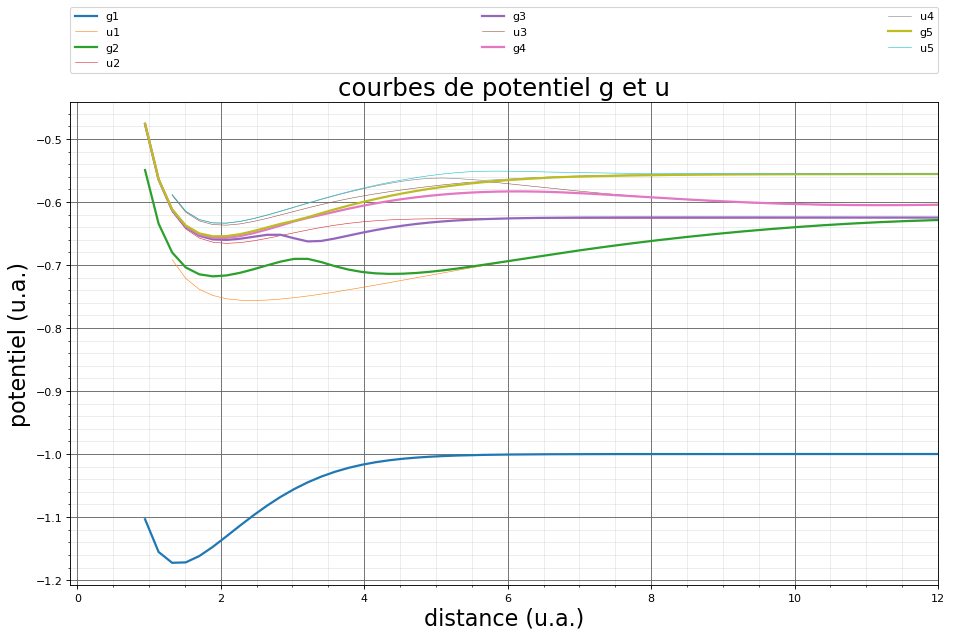

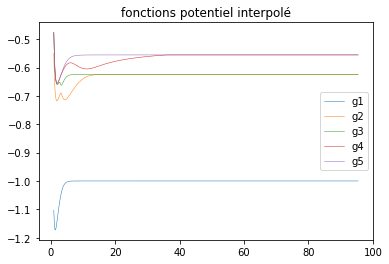

In [3]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

#############################################################################
# ouverture des fichiers et lecture des données
with open ("pec_sigmag.txt", "r") as fichierg: # ouverture du fichier pec_sigmag.txt en mode lecture
    fichierg = open("pec_sigmag.txt", "r")

echelle=1/0.529177

data_g = np.loadtxt(fichierg)
xg_read = data_g[:,0]*echelle


with open ("pec_sigmau.txt", "r") as fichieru: # ouverture du fichier pec_sigmau.txt en mode lecture
    fichieru = open("pec_sigmau.txt", "r")
data_u = np.loadtxt(fichieru)
xu_read = data_u[:,0]*echelle

#########################################################################
# création des fonctions Vgi(x) et Vui(x) qui sont inexées et interpolent les potentiels Vgi et Vui


g1=interp1d(xg_read, data_g[:,1], kind='cubic')
g2=interp1d(xg_read, data_g[:,2], kind='cubic')
g3=interp1d(xg_read, data_g[:,3], kind='cubic')
g4=interp1d(xg_read, data_g[:,4], kind='cubic')
g5=interp1d(xg_read, data_g[:,5], kind='cubic')


Vg = [g1,g2,g3,g4,g5]


g6=interp1d(xu_read, data_u[:,1], kind='cubic')
g7=interp1d(xu_read, data_u[:,2], kind='cubic')
g8=interp1d(xu_read, data_u[:,3], kind='cubic')
g9=interp1d(xu_read, data_u[:,4], kind='cubic')
g10=interp1d(xu_read, data_u[:,5], kind='cubic')

Vu = [g6,g7,g8,g9,g10]

#############################################################################
# impressions et plot
figure(figsize=(14,8), dpi=80)
rcParams['axes.labelsize'] = 20

# Lignes d'unités principales
plt.grid(b=True, which='major', color='#666666', linestyle='-')

# Lignes de subdivision
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)



xlabel("distance (u.a.)")
ylabel("potentiel (u.a.)")
plt.xlim(-0.1,12)

for ip in range(1,6):
    plt.plot(xg_read, data_g[:,ip],linewidth=2.0, label="g%d"%(ip,))
    plt.plot(xu_read, data_u[:,ip],linewidth=0.5, label="u%d"%(ip,))


plt.title ("courbes de potentiel g et u", fontsize=22)
plt.legend(bbox_to_anchor=(0., 1.06, 1., .106), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)

plt.show()


plt.title ("fonctions potentiel interpolé")
for ip in range(0,5):
        jp=ip+1
        plt.plot(xg_read, Vg[ip](xg_read), linewidth=0.5, label="g%d"%(jp,))


    
plt.legend(loc='best', frameon= True)
plt.show()



# Utilisation de leapfrog sur une fonction potentiel (état fondamental).

On envisage un rapprochement de H+ et H-, qui s'effectuerait selon une des courbes de potentiel $g1$ à $g5$ ci-dessus. On va donc travailler dans le référentiel du centre de masse de $H_2$ et considérer que la masse réduite de l'atome $\frac {m_p^2}{2m_p}=\frac{m_p}{2}$ se déplace dans le potentiel donné.

Dans le système d'unités atomiques l'unité de masse atomique est  𝑚𝑒∼9,109383× 10−31𝑘𝑔 .

Le proton ayant une masse de  1,672610−27𝑘𝑔 , la masse réduite de l'atome sera en u.a.  918,06. Comme on néglige la masse de l'électron on retient le coefficient de 918 pour les calculs.

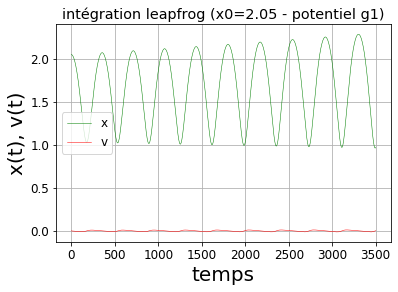

In [7]:


x0=2.05 # On doit avoir 1.245> x0 > 0.5
v0=0.

###############################################################################
# masse à prendre en compte

m=918

###############################################################################
# entrée des paramètres temporels - limite de temps tps pas temporel Mm
Mm = 10000    

tps=3500
tp=np.linspace(0,tps,Mm)
dtp = tp[1] - tp[0]


###############################################################################
# calcul de la valeur de la dérivée du potentiel en un point x
def derivpot(z):
               
        h=0.00001
        pot=(g1(z+h)-g1(z))/h
        return pot

    
###############################################################################
# création de la fonction resoudre qui donne position et vitesses par la méthode leapfrog (coeur du programme)
def resoudre(x0,v0, Mm):
    
########################
# Initialisation à 0 des variables, et Conditions initiales
    x = zeros(Mm)
    v = zeros(Mm)
    x[0] = x0
    v[0] = v0
    
########################
# Intégration "leapfrog"
    k0= derivpot(x0)/m
    
    for i in range(0,Mm-1):
        v[i + 1] = v[i] - dtp*k0
        x[i + 1] = x[i] + dtp*v[i + 1]
        if i!=0: k0=derivpot(x[i])/m
            
    return x,v
 


x,v = resoudre(x0,v0,Mm)






###############################################################################
# représentation graphique leapfrog
rcParams["axes.grid"] = True
rcParams['font.size'] = 12
rcParams['axes.labelsize'] = 20
figure()
plt.plot(tp,x,'g',linewidth=0.5, label='x')
plt.plot(tp,v,'r',linewidth=0.5, label='v')
xlabel("temps")
ylabel("x(t), v(t)")

titre1 = "intégration leapfrog (x0={} - potentiel g1)".format(x0)

plt.title (titre1)
plt.legend(loc='best', frameon= True)

###############################################################################
show()
###############################################################################




L'encart ci-dessous est une tentative pour utiliser une fonction indexée dans le programme leapfrog.
Les paramètres à définir sont :

   - les conditions initiales ($x_0$ et $v_0$).
    
   - la courbe de potentiel ($g_1$, $g_2$, $g_3$, $g_4$, $g_5$, )
    
   - le pas temporel d'intégration, défini par son inverse entier $Mm$
    
   - la durée d'intégration $tps$
   
   

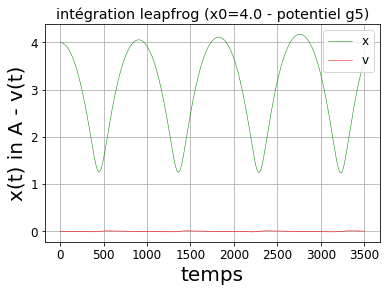

In [10]:

x0=4. 
v0=0.

###############################################################################
# masse à prendre en compte et index de la fonction de potentiel

m=918


ipot=5


###############################################################################
# entrée des paramètres temporels - limite de temps tps pas temporel Mm
Mm = 10000    

tps=3500
tp=np.linspace(0,tps,Mm)
dtp = tp[1] - tp[0]


###############################################################################
# calcul de la valeur de la dérivée du potentiel en un point x
def derivpot(z, i):
        for j in range(1,2):       
            if i==1: 
                fpot=g1
                break
            elif i==2: 
                fpot=g2
                break
            elif i==3: 
                fpot=g3
                break
            elif i==4: 
                fpot=g4
                break
            if i==5: 
                fpot=g5
                break
            elif i==6: 
                fpot=u1
                break
            elif i==7: 
                fpot=u2
                break
            elif i==8: 
                fpot=u3
                break
            elif i==9: 
                fpot=u4
                break
            elif i==10: fpot=u5
 
        h=0.00001
        pot=(fpot(z+h)-fpot(z))/h
      
        return pot

    
###############################################################################
# création de la fonction resoudre qui donne position et vitesses par la méthode leapfrog (coeur du programme)
def resoudre(x0,v0, Mm, ipot):
    
########################
# Initialisation à 0 des variables, et Conditions initiales
    x = zeros(Mm)
    v = zeros(Mm)
    x[0] = x0
    v[0] = v0
    
########################
# Intégration "leapfrog"
    k0= derivpot(x0,ipot)/m
    
    for i in range(0,Mm-1):
        v[i + 1] = v[i] - dtp*k0
        x[i + 1] = x[i] + dtp*v[i + 1]
        if i!=0: k0=derivpot(x[i],ipot)/m
            
    return x,v
 


x,v = resoudre(x0,v0,Mm,ipot)






###############################################################################
# représentation graphique leapfrog
rcParams["axes.grid"] = True
rcParams['font.size'] = 12
rcParams['axes.labelsize'] = 20
figure()
plt.plot(tp,x,'g',linewidth=0.5, label='x')
plt.plot(tp,v,'r',linewidth=0.5, label='v')
xlabel("temps")

express1="x(t) in A - v(t)"

ylabel(express1)

titre1 = "intégration leapfrog (x0={} - potentiel g{})".format(x0, ipot)

plt.title (titre1)
plt.legend(loc='best', frameon= True)

###############################################################################
show()
###############################################################################




La version ci-dessous est améliorée et plus compacte. 

Elle impose cependant de rentrer directement la fonction et non pas un indice entier.

{'Potentiel', 'g5'}


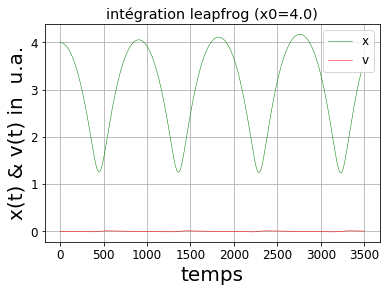

In [12]:

x0=4. 
v0=0.

###############################################################################
# masse à prendre en compte et index de la fonction de potentiel

m=918


Potentiel=g5

###############################################################################
# entrée des paramètres temporels - limite de temps tps pas temporel Mm
Mm = 10000    
tps=3500
tp=np.linspace(0,tps,Mm)
dtp = tp[1] - tp[0]


###############################################################################
# calcul de la valeur de la dérivée du potentiel en un point x
def derivpot(z, Potentiel):
        h=0.00001
        pot=(Potentiel(z+h)-Potentiel(z))/h
        return pot
    
###############################################################################
# création de la fonction resoudre qui donne position et vitesses par la méthode leapfrog (coeur du programme)
def resoudre(x0,v0, Mm, Potentiel):
    
########################
# Initialisation à 0 des variables, et Conditions initiales
    x = zeros(Mm)
    v = zeros(Mm)
    x[0] = x0
    v[0] = v0
    
########################
# Intégration "leapfrog"
    k0= derivpot(x0,Potentiel)/m
    for i in range(0,Mm-1):
        v[i + 1] = v[i] - dtp*k0
        x[i + 1] = x[i] + dtp*v[i + 1]
        if i!=0: k0=derivpot(x[i],Potentiel)/m
            
    return x,v
############################################################################### 


x,v = resoudre(x0,v0,Mm,Potentiel)


###############################################################################
# représentation graphique leapfrog

texte = set(varname for varname, varval in globals().items() if varval is Potentiel)
print(texte)

rcParams["axes.grid"] = True
rcParams['font.size'] = 12
rcParams['axes.labelsize'] = 20
figure()
plt.plot(tp,x,'g',linewidth=0.5, label='x')
plt.plot(tp,v,'r',linewidth=0.5, label='v')
xlabel("temps")

express1="x(t) & v(t) in  u.a."

ylabel(express1)

titre1 = "intégration leapfrog (x0={})".format(x0, Potentiel)

plt.title (titre1)
plt.legend(loc='best', frameon= True)

###############################################################################
show()
###############################################################################

    

# Mouvements sur le même potentiel, en différents points
Le programme ci-dessous permet d'imprimer plusieurs plots à différentes valeurs de départ pour les conditions initiales, en conservant la même fonction potentiel.

On a modélisé les 5 potentiel g.

{'Potentiel', 'g1'}


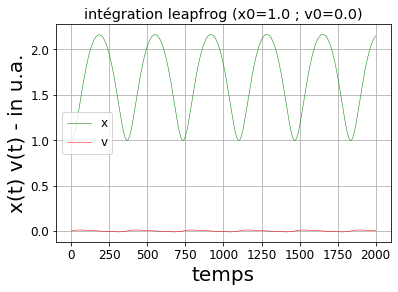

{'Potentiel', 'g1'}


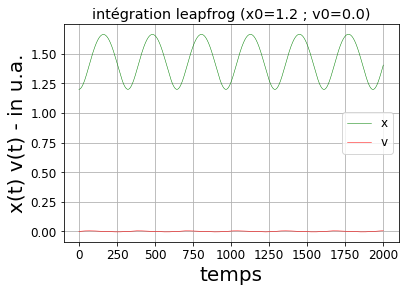

{'Potentiel', 'g1'}


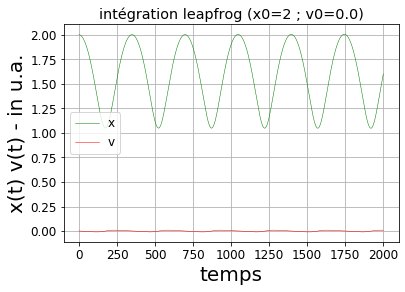

{'Potentiel', 'g1'}


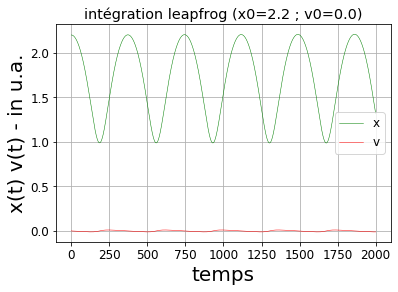

In [13]:

x0=1. # Les valeurs autorisées dépendent du potentiel
v0=0.

###############################################################################
# masse à prendre en compte et index de la fonction de potentiel

m=918


Potentiel=g1
vue=[x0, 1.2, 2, 2.2]
###############################################################################
# entrée des paramètres temporels - limite de temps tps pas temporel Mm
Mm = 100000    
tps=2000
tp=np.linspace(0,tps,Mm)
dtp = tp[1] - tp[0]
###############################################################################
# calcul de la valeur de la dérivée du potentiel en un point x
def derivpot(z, Potentiel):
        h=0.00001
        pot=(Potentiel(z+h)-Potentiel(z))/h      
        return pot    
###############################################################################
# création de la fonction resoudre qui donne position et vitesses par la méthode leapfrog (coeur du programme)
def resoudre(x0,v0, Mm, Potentiel):    
########################
# Initialisation à 0 des variables, et Conditions initiales
    x = zeros(Mm)
    v = zeros(Mm)
    x[0] = x0
    v[0] = v0    
########################
# Intégration "leapfrog"
    k0= derivpot(x0,Potentiel)/m    
    for i in range(0,Mm-1):
        v[i + 1] = v[i] - dtp*k0
        x[i + 1] = x[i] + dtp*v[i + 1]
        if i!=0: k0=derivpot(x[i],Potentiel)/m            
    return x,v
############################################################################### 
for iplot in range(0,4):
    x1=vue[iplot]
    x,v = resoudre(x1,v0,Mm,Potentiel)
    texte = set(varname for varname, varval in globals().items() if varval is Potentiel)
    print(texte)
    rcParams["axes.grid"] = True
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 20
    figure()
    plt.plot(tp,x,'g',linewidth=0.5, label='x')
    plt.plot(tp,v,'r',linewidth=0.5, label='v')
    xlabel("temps")
    express1="x(t) v(t) - in u.a."
    ylabel(express1)
    titre1 = "intégration leapfrog (x0={} ; v0={})".format(x1,v0)
    plt.title (titre1)
    plt.legend(loc='best', frameon= True)
###############################################################################
    show()
###############################################################################

{'Potentiel', 'g2'}


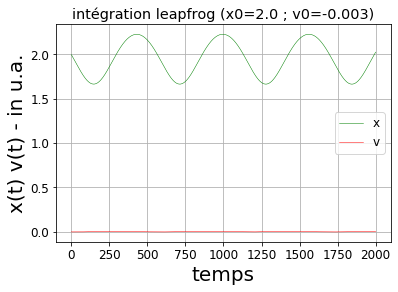

{'Potentiel', 'g2'}


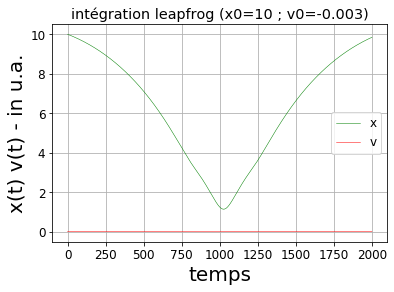

{'Potentiel', 'g2'}


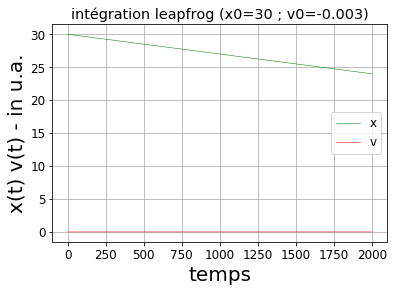

{'Potentiel', 'g2'}


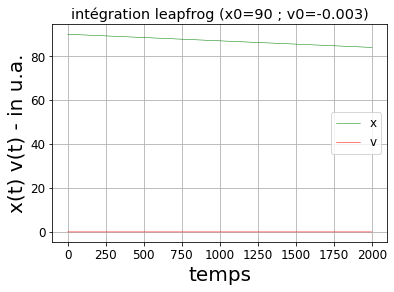

In [18]:
x0=2.0 # Les valeurs autorisées dépendent du potentiel
v0=-0.003

###############################################################################
# masse à prendre en compte et index de la fonction de potentiel

m=918

Potentiel=g2
vue=[x0, 10, 30, 90]
###############################################################################
# entrée des paramètres temporels - limite de temps tps pas temporel Mm
Mm = 100000    
tps=2000
tp=np.linspace(0,tps,Mm)
dtp = tp[1] - tp[0]


###############################################################################
# calcul de la valeur de la dérivée du potentiel en un point x
def derivpot(z, Potentiel):
        h=0.00001
        pot=(Potentiel(z+h)-Potentiel(z))/h
      
        return pot

    
###############################################################################
# création de la fonction resoudre qui donne position et vitesses par la méthode leapfrog (coeur du programme)
def resoudre(x0,v0, Mm, Potentiel):
    
########################
# Initialisation à 0 des variables, et Conditions initiales
    x = zeros(Mm)
    v = zeros(Mm)
    x[0] = x0
    v[0] = v0
    
########################
# Intégration "leapfrog"
    k0= derivpot(x0,Potentiel)/m
    
    for i in range(0,Mm-1):
        v[i + 1] = v[i] - dtp*k0
        x[i + 1] = x[i] + dtp*v[i + 1]
        if i!=0: k0=derivpot(x[i],Potentiel)/m
            
    return x,v
############################################################################### 



for iplot in range(0,4):
    x1=vue[iplot]
    x,v = resoudre(x1,v0,Mm,Potentiel)

    texte = set(varname for varname, varval in globals().items() if varval is Potentiel)
    print(texte)
    
    rcParams["axes.grid"] = True
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 20
    figure()
    plt.plot(tp,x,'g',linewidth=0.5, label='x')
    plt.plot(tp,v,'r',linewidth=0.5, label='v')
    xlabel("temps")

    express1="x(t) v(t) - in u.a."

    ylabel(express1)
    titre1 = "intégration leapfrog (x0={} ; v0={})".format(x1,v0)

    plt.title (titre1)
    plt.legend(loc='best', frameon= True)

###############################################################################
    show()
###############################################################################

{'Potentiel', 'g3'}


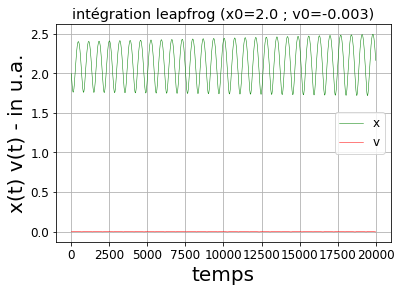

{'Potentiel', 'g3'}


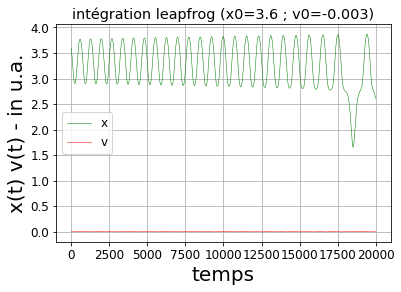

{'Potentiel', 'g3'}


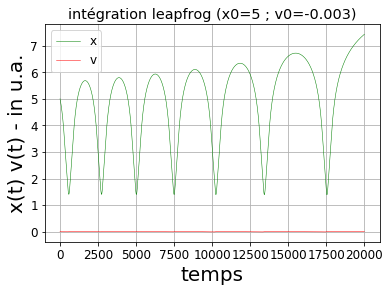

{'Potentiel', 'g3'}


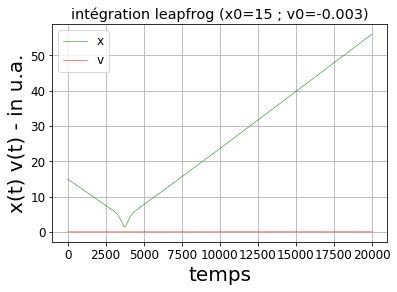

In [19]:
x0=2.0 # Les valeurs autorisées dépendent du potentiel
v0=-0.003

###############################################################################
# masse à prendre en compte et index de la fonction de potentiel

m=918

Potentiel=g3
vue=[x0, 3.6, 5, 15]
###############################################################################
# entrée des paramètres temporels - limite de temps tps pas temporel Mm
Mm = 100000    
tps=20000
tp=np.linspace(0,tps,Mm)
dtp = tp[1] - tp[0]


###############################################################################
# calcul de la valeur de la dérivée du potentiel en un point x
def derivpot(z, Potentiel):
        h=0.00001
        pot=(Potentiel(z+h)-Potentiel(z))/h
      
        return pot

    
###############################################################################
# création de la fonction resoudre qui donne position et vitesses par la méthode leapfrog (coeur du programme)
def resoudre(x0,v0, Mm, Potentiel):
    
########################
# Initialisation à 0 des variables, et Conditions initiales
    x = zeros(Mm)
    v = zeros(Mm)
    x[0] = x0
    v[0] = v0
    
########################
# Intégration "leapfrog"
    k0= derivpot(x0,Potentiel)/m
    
    for i in range(0,Mm-1):
        v[i + 1] = v[i] - dtp*k0
        x[i + 1] = x[i] + dtp*v[i + 1]
        if i!=0: k0=derivpot(x[i],Potentiel)/m
            
    return x,v
############################################################################### 



for iplot in range(0,4):
    x1=vue[iplot]
    x,v = resoudre(x1,v0,Mm,Potentiel)

    texte = set(varname for varname, varval in globals().items() if varval is Potentiel)
    print(texte)
    
    rcParams["axes.grid"] = True
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 20
    figure()
    plt.plot(tp,x,'g',linewidth=0.5, label='x')
    plt.plot(tp,v,'r',linewidth=0.5, label='v')
    xlabel("temps")

    express1="x(t) v(t) - in u.a."

    ylabel(express1)
    titre1 = "intégration leapfrog (x0={} ; v0={})".format(x1,v0)

    plt.title (titre1)
    plt.legend(loc='best', frameon= True)

###############################################################################
    show()
###############################################################################

    

{'Potentiel', 'g3'}


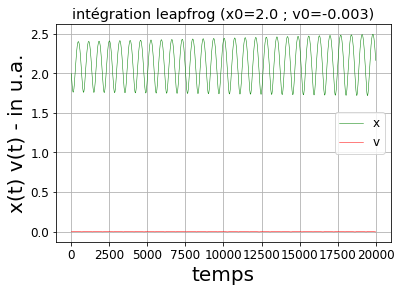

{'Potentiel', 'g3'}


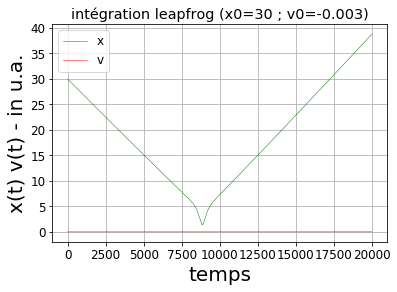

{'Potentiel', 'g3'}


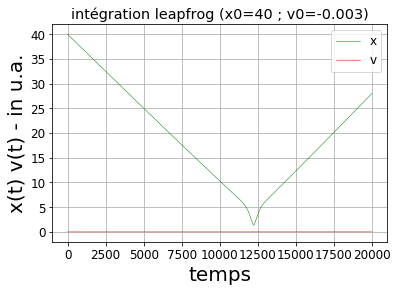

{'Potentiel', 'g3'}


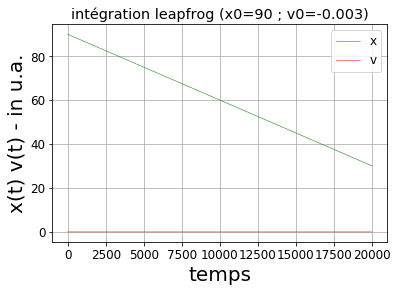

In [21]:
x0=2.0 # Les valeurs autorisées dépendent du potentiel
v0=-0.003

###############################################################################
# masse à prendre en compte et index de la fonction de potentiel

m=918



Potentiel=g3
vue=[x0, 30, 40, 90]
###############################################################################
# entrée des paramètres temporels - limite de temps tps pas temporel Mm
Mm = 100000    
tps=20000
tp=np.linspace(0,tps,Mm)
dtp = tp[1] - tp[0]

###############################################################################
# calcul de la valeur de la dérivée du potentiel en un point x
def derivpot(z, Potentiel):
        h=0.00001
        pot=(Potentiel(z+h)-Potentiel(z))/h
      
        return pot   
###############################################################################
# création de la fonction resoudre qui donne position et vitesses par la méthode leapfrog (coeur du programme)
def resoudre(x0,v0, Mm, Potentiel):
    
########################
# Initialisation à 0 des variables, et Conditions initiales
    x = zeros(Mm)
    v = zeros(Mm)
    x[0] = x0
    v[0] = v0
    
########################
# Intégration "leapfrog"
    k0= derivpot(x0,Potentiel)/m
    
    for i in range(0,Mm-1):
        v[i + 1] = v[i] - dtp*k0
        x[i + 1] = x[i] + dtp*v[i + 1]
        if i!=0: k0=derivpot(x[i],Potentiel)/m
            
    return x,v
############################################################################### 
for iplot in range(0,4):
    x1=vue[iplot]
    x,v = resoudre(x1,v0,Mm,Potentiel)
    texte = set(varname for varname, varval in globals().items() if varval is Potentiel)
    print(texte)   
    rcParams["axes.grid"] = True
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 20
    figure()
    plt.plot(tp,x,'g',linewidth=0.5, label='x')
    plt.plot(tp,v,'r',linewidth=0.5, label='v')
    xlabel("temps")
    express1="x(t) v(t) - in u.a."
    ylabel(express1)
    titre1 = "intégration leapfrog (x0={} ; v0={})".format(x1,v0)
    plt.title (titre1)
    plt.legend(loc='best', frameon= True)
###############################################################################
    show()
###############################################################################

{'Potentiel', 'g4'}


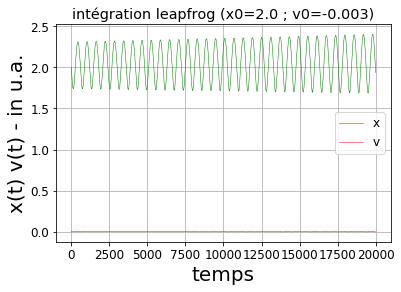

{'Potentiel', 'g4'}


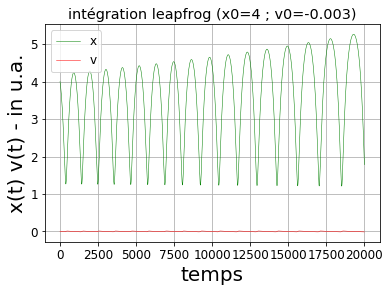

{'Potentiel', 'g4'}


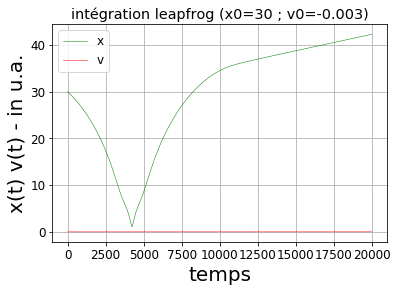

{'Potentiel', 'g4'}


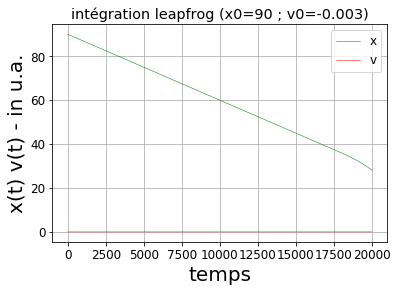

In [22]:
x0=2.0 # Les valeurs autorisées dépendent du potentiel
v0=-0.003

###############################################################################
# masse à prendre en compte et index de la fonction de potentiel

m=918


Potentiel=g4
vue=[x0, 4, 30, 90]
###############################################################################
# entrée des paramètres temporels - limite de temps tps pas temporel Mm
Mm = 100000    
tps=20000
tp=np.linspace(0,tps,Mm)
dtp = tp[1] - tp[0]
###############################################################################
# calcul de la valeur de la dérivée du potentiel en un point x
def derivpot(z, Potentiel):
        h=0.00001
        pot=(Potentiel(z+h)-Potentiel(z))/h      
        return pot    
###############################################################################
# création de la fonction resoudre qui donne position et vitesses par la méthode leapfrog (coeur du programme)
def resoudre(x0,v0, Mm, Potentiel):    
########################
# Initialisation à 0 des variables, et Conditions initiales
    x = zeros(Mm)
    v = zeros(Mm)
    x[0] = x0
    v[0] = v0    
########################
# Intégration "leapfrog"
    k0= derivpot(x0,Potentiel)/m    
    for i in range(0,Mm-1):
        v[i + 1] = v[i] - dtp*k0
        x[i + 1] = x[i] + dtp*v[i + 1]
        if i!=0: k0=derivpot(x[i],Potentiel)/m           
    return x,v
############################################################################### 
for iplot in range(0,4):
    x1=vue[iplot]
    x,v = resoudre(x1,v0,Mm,Potentiel)
    texte = set(varname for varname, varval in globals().items() if varval is Potentiel)
    print(texte)
    rcParams["axes.grid"] = True
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 20
    figure()
    plt.plot(tp,x,'g',linewidth=0.5, label='x')
    plt.plot(tp,v,'r',linewidth=0.5, label='v')
    xlabel("temps")
    express1="x(t) v(t) - in u.a."
    ylabel(express1)
    titre1 = "intégration leapfrog (x0={} ; v0={})".format(x1,v0)
    plt.title (titre1)
    plt.legend(loc='best', frameon= True)
###############################################################################
    show()
###############################################################################

{'Potentiel', 'g5'}


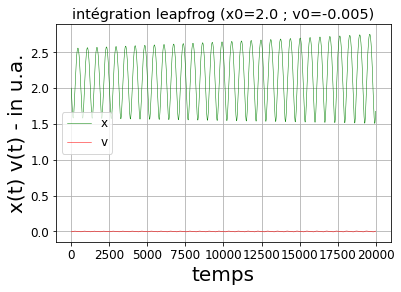

{'Potentiel', 'g5'}


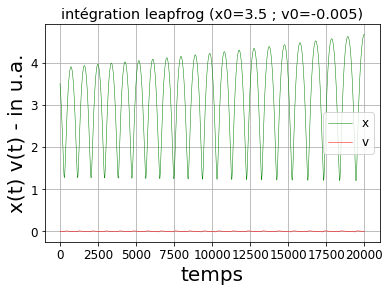

{'Potentiel', 'g5'}


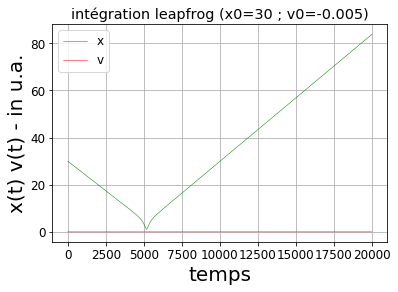

{'Potentiel', 'g5'}


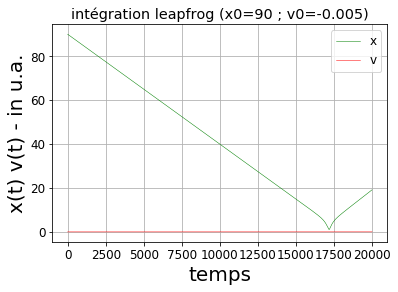

In [24]:
x0=2.0 # Les valeurs autorisées dépendent du potentiel
v0=-0.005

###############################################################################
# masse à prendre en compte et index de la fonction de potentiel

m=918


Potentiel=g5
vue=[x0, 3.5, 30, 90]
###############################################################################
# entrée des paramètres temporels - limite de temps tps pas temporel Mm
Mm = 100000    
tps=20000
tp=np.linspace(0,tps,Mm)
dtp = tp[1] - tp[0]


###############################################################################
# calcul de la valeur de la dérivée du potentiel en un point x
def derivpot(z, Potentiel):
        h=0.00001
        pot=(Potentiel(z+h)-Potentiel(z))/h
      
        return pot

    
###############################################################################
# création de la fonction resoudre qui donne position et vitesses par la méthode leapfrog (coeur du programme)
def resoudre(x0,v0, Mm, Potentiel):
    
########################
# Initialisation à 0 des variables, et Conditions initiales
    x = zeros(Mm)
    v = zeros(Mm)
    x[0] = x0
    v[0] = v0
    
########################
# Intégration "leapfrog"
    k0= derivpot(x0,Potentiel)/m
    
    for i in range(0,Mm-1):
        v[i + 1] = v[i] - dtp*k0
        x[i + 1] = x[i] + dtp*v[i + 1]
        if i!=0: k0=derivpot(x[i],Potentiel)/m
            
    return x,v
############################################################################### 



for iplot in range(0,4):
    x1=vue[iplot]
    x,v = resoudre(x1,v0,Mm,Potentiel)

    texte = set(varname for varname, varval in globals().items() if varval is Potentiel)
    print(texte)
    
    rcParams["axes.grid"] = True
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 20
    figure()
    plt.plot(tp,x,'g',linewidth=0.5, label='x')
    plt.plot(tp,v,'r',linewidth=0.5, label='v')
    xlabel("temps")

    express1="x(t) v(t) - in u.a."

    ylabel(express1)
    titre1 = "intégration leapfrog (x0={} ; v0={})".format(x1,v0)

    plt.title (titre1)
    plt.legend(loc='best', frameon= True)

###############################################################################
    show()
###############################################################################

    